## Basic OCR function

Input is an image of a table with some coloring challenges.  Required data are the columns of Player, Grade, and Comment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime as dt

import re
#import math
from scipy import stats

import urllib.request
from PIL import Image, ImageEnhance, ImageFilter

import pytesseract
from pytesseract import image_to_string

start=dt.datetime.now()
pd.set_option('display.max_columns', None)

cwd = os.getcwd()
data_dir=cwd+'/data/'
player_data_file='C:\\Users\\bill_\\Fantasy_Football_2019\\FFootball_Data_Gathering_p2_7\\player_data_C_2019.csv'

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

data_dir=os.getcwd()+'\\data\\'

print('Initializations done.')


Initializations done.


## Read Image

In [2]:
##############################################
# Used in original app, not used in this demo
# left as example

def get_image(URL):

    with urllib.request.urlopen(URL) as url:
        with open('temp.jpg', 'wb') as f:
            f.write(url.read())

    img = Image.open('temp.jpg')
    return img


def adj_image(x,blue_adjustment=10,green_adjustment=0,red_adjustment=0):
    #im = Image.open(x)
    im=x
 
    data = np.array(im)   # "data" is a height x width x 4 numpy array
    red, green, blue, alpha = data.T # Temporarily unpack the bands for readability
 
        # Replace light blue with white... (leaves alpha values alone...)
    screen=225
    shade_areas = (red >=screen-red_adjustment) | (blue >= screen-blue_adjustment) | (green ==screen-green_adjustment)
    data[..., :-1][shade_areas.T] = (255, 255, 255) # Transpose back needed
 
    return Image.fromarray(data)

##############################################



In [3]:
def convert_image_string_csv(da_image,scale_f=3.85,contrast=1.55,sharpness=2.55):
    '''scale, contrast, sharpness defaults set based on original 43x work.
    png_file expects full pathname.'''
    
    #screen_shot=get_image(web_image_address)
    screen_shot=da_image
    width,height=screen_shot.size
    width=int(width*scale_f)
    height=int(height*scale_f)
                
    screen_shot = screen_shot.resize((width, height), Image.BILINEAR)
    screen_shot = ImageEnhance.Color(screen_shot).enhance(0.0)
    screen_shot = ImageEnhance.Contrast(screen_shot).enhance(contrast)
    screen_shot = ImageEnhance.Sharpness(screen_shot).enhance(sharpness)
    
    #plt.imshow(screen_shot)
    #plt.show()
    
    
    str1=image_to_string(screen_shot)
    return screen_shot,str1

# Note:  not refactored.  The following could be combined with the above.
def convert_tmp_image_big_string_csv(tmp_img,scale_f=3.85,contrast=1.55,sharpness=2.55):
    '''scale, contrast, sharpness defaults set based on original 43x work.
    png_file expects full pathname'''

    screen_shot=img = Image.open(data_dir+'temp.jpg')
    print('Opened image')
    width,height=screen_shot.size
    width=int(width*scale_f)
    height=int(height*scale_f)

    screen_shot = screen_shot.resize((width, height), Image.BILINEAR)
    screen_shot = ImageEnhance.Color(screen_shot).enhance(0.0)
    screen_shot = ImageEnhance.Contrast(screen_shot).enhance(contrast)
    screen_shot = ImageEnhance.Sharpness(screen_shot).enhance(sharpness)


    print('Image found and enhanced.  Converting')


    str1=image_to_string(screen_shot)
    return screen_shot,str1


def get_grades(img,blue_adjustment=75):

    my_test= Image.open(data_dir+'temp.jpg')
    print('Opened image')
    #my_test=Image.open(img)
    plt.figure(figsize=(6,6),dpi=100)
    plt.imshow(my_test)
    plt.show()

    print('Moving on')
    quality=[]
    flag1=False
    flag2=False
    i=20

    while i<200:
        my_test=adj_image(my_test,blue_adjustment=i)
        table_pic,pic_str=convert_image_string_csv(my_test,scale_f=5,contrast=1.5,sharpness=3)
        pic_list=[x for x in pic_str.split('\n') if x!='' ]

        try:
            player_indy=pic_list.index('Start or Sit?')
            flag1=True
        except:
            flag1=False

        try:
            grade_search=[x for x in pic_list if x.find('Grade')>=0]
            grades_indy=pic_list.index(grade_search[0])
            flag2=True

        except:
            flag2=False

        if flag1 and flag2:
            i=205
        else:
            flag1=False
            flag2=False
            i+=5

    players=pic_list[1:player_indy]
    grades=pic_list[player_indy+1:grades_indy]

    df=pd.DataFrame(columns=['Player','Grade','Comment'])
    df['Player']=players

    def do_grades(x,thing):

        if len(x.split(','))==2:
            tmp=x.split(',')
        elif len(x.split('.'))==2:
            tmp=x.split('.')
        else:
            tmp=[np.nan,np.nan]
        if thing=='Grade':
            return tmp[0]
        else:
            return tmp[1]

    df['Grade']=[do_grades(x,'Grade') for x in grades]
    df['Comment']=[do_grades(x,'Comment') for x in grades]
    return df

print('Loads done')

Loads done


Opened image
Image found and enhanced.  Converting
Opened image


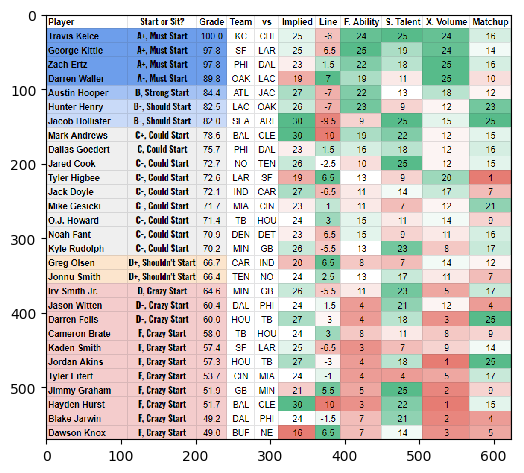

Moving on
Completed processing.  
DataFrame Head(10):
            Player Grade        Comment
0     Travis Kelce    A+     Must Start
1    George Kittle    A+     Must Start
2        Zach Ertz    A+     Must Start
3    Darren Waller    A-     Must Start
4    Austin Hooper     B   Strang Start
5     Hunter Henry    B-   Should Start
6  Jacob Hollister    B-   Should Start
7     Mark Andrews    C+    Could Start
8   Dallas Goedert     C    Could Start
9       Jared Cook    C-    Could Start


In [4]:
positions=[data_dir+'temp.jpg']

player_grades=pd.DataFrame()

for p in positions:
    screen_shot,str1=convert_tmp_image_big_string_csv(p)
    grades=get_grades(screen_shot,blue_adjustment=105)
    print('Completed processing.  \nDataFrame Head(10):')
    print(grades.head(10))